In [1]:
from collections import defaultdict
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import re

In [2]:
# %pip install Jinja2

Visualisation on **validation** set

In [3]:
x_labels = {'electra-base-discriminator': 'ELECTRA', 'roberta-base': 'RoBERTa', 'bert-base-uncased': 'BERT', 'distilbert-base-uncased': 'DistilBERT', 'elmo':'ELMo'}
hue_labels = {'kaggle_1000': 'Fake and Real News', 'fake_real_1000': 'Fake or Real News', 'liar_1000': 'Liar'}

In [17]:
# Plot results baseline
path = "models/text-based"

res = defaultdict(dict)
x_values, y_values, hue_values = [], [], []

for root, dirs, files in os.walk(path):
    mets = []
    for file in files:
        if file == 'trainer_state.json':
            model_name = os.path.basename(os.path.dirname(os.path.dirname(root)))
            x_values.append(x_labels[model_name])

            dataset = os.path.basename(os.path.dirname(root))
            hue_values.append(hue_labels[dataset])

            trainer_state = os.path.join(root, file)

            with open(trainer_state) as f:
                data = json.load(f)

            f1 = data["log_history"][1]["eval_f1"]

            res[x_labels[model_name]][hue_labels[dataset]] = "{:.2f}".format(f1)
            
            y_values.append(float("{:.2f}".format(f1)))

        if 'elmo' in os.path.basename(os.path.dirname(root)):
            if file.endswith('.json'):
                mets.append(file)    

    mets_sorted = sorted(mets, key=lambda x: int(x.split(".")[0][-1]), reverse=True)

    if mets_sorted:
        model_name = os.path.basename(os.path.dirname(root))
        x_values.append(x_labels[model_name])

        dataset = os.path.basename(root)
        hue_values.append(hue_labels[dataset])

        metrics = mets_sorted[0]
        best_mets_file = os.path.join(root, metrics)

        with open(best_mets_file) as f:
            data = json.load(f)
        f1 = data["best_validation_f1"]
        print(f1)
        res[x_labels[model_name]][hue_labels[dataset]] = "{:.2f}".format(f1)            
        y_values.append(float("{:.2f}".format(f1)))     


0.9411765336990356
0.699999988079071
0.6086956262588501


In [18]:
res

defaultdict(dict,
            {'ELMo': {'Fake and Real News': '0.94',
              'Fake or Real News': '0.70',
              'Liar': '0.61'},
             'ELECTRA': {'Fake and Real News': '0.94',
              'Fake or Real News': '0.79',
              'Liar': '0.67'},
             'RoBERTa': {'Fake and Real News': '0.93',
              'Fake or Real News': '0.78',
              'Liar': '0.67'},
             'BERT': {'Fake and Real News': '0.97',
              'Fake or Real News': '0.56',
              'Liar': '0.68'},
             'DistilBERT': {'Fake and Real News': '0.91',
              'Fake or Real News': '0.75',
              'Liar': '0.67'}})

In [19]:
print(y_values)

[0.94, 0.7, 0.61, 0.94, 0.79, 0.79, 0.67, 0.67, 0.93, 0.93, 0.78, 0.78, 0.67, 0.67, 0.97, 0.97, 0.56, 0.56, 0.68, 0.68, 0.91, 0.75, 0.75, 0.67, 0.67]


In [20]:
print(set(x_values), set(hue_values))

{'BERT', 'DistilBERT', 'ELMo', 'RoBERTa', 'ELECTRA'} {'Fake and Real News', 'Fake or Real News', 'Liar'}


In [21]:
scores = defaultdict(list)

for model_name, score_dict in res.items():
    for dataset, score in score_dict.items():
        scores[dataset].append(score)


df = pd.DataFrame(scores, index=res)


In [22]:
print(df.to_latex())

\begin{tabular}{llll}
\toprule
 & Fake and Real News & Fake or Real News & Liar \\
\midrule
ELMo & 0.94 & 0.70 & 0.61 \\
ELECTRA & 0.94 & 0.79 & 0.67 \\
RoBERTa & 0.93 & 0.78 & 0.67 \\
BERT & 0.97 & 0.56 & 0.68 \\
DistilBERT & 0.91 & 0.75 & 0.67 \\
\bottomrule
\end{tabular}



In [23]:
yticks = ["{:.1f}".format(i) for i in list(np.arange(0,1.1,0.1))]
yticks

['0.0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0']

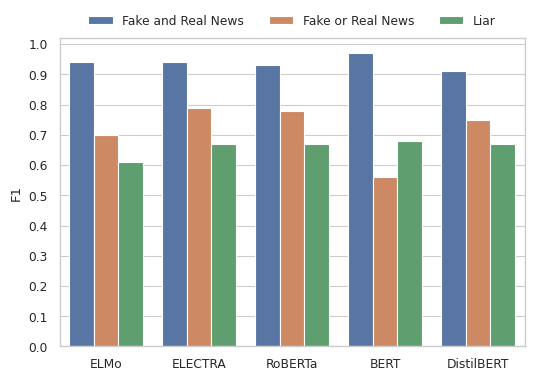

In [25]:
sns.set_style("whitegrid")
sns.set_context('paper')

plt.figure(figsize=(6, 4))

ax = sns.barplot(x=x_values, y=y_values, hue=hue_values, palette="deep")
sns.move_legend(ax, "lower center", 
    bbox_to_anchor=(.5, 1), ncol=4, title=None, frameon=False)

ax.set_yticks(list(np.arange(0,1.1,0.1)))
# plt.xlabel('Models')
plt.ylabel('F1')

plt.savefig('pipeline/text-based/results/figures/baseline.png')